# Homework 2 (100 Points)

The goal of this homework is to get more practice with pandas and get practice with clustering on various datasets.



## Exercise 1 - (50 points)

This exercise will be using the [Airbnb dataset](http://insideairbnb.com/get-the-data.html) for NYC called `listings.csv`. You can download it directly [here](http://data.insideairbnb.com/united-states/ny/new-york-city/2021-11-02/visualisations/listings.csv)

a) Produce a Heatmap using the Folium package (you can install it using pip) of the mean listing price per location (lattitude and longitude) over the NYC map. (5 points)

Hints:
1. generate a base map of NYC to plot over: default_location=[40.693943, -73.985880] 
2. generate an HTML file named `index.html` - open it in your browser and you'll see the heatmap 



In [ ]:
import folium
from folium.plugins import HeatMap
import pandas as pd
from collections import defaultdict

In [ ]:
def display(dataframe: pd.DataFrame, weight='price', zoom= 11):
    prices = defaultdict(list)
    
    for row in dataframe.iterrows():
        prices[
            (row[1]['latitude'], row[1]['longitude'])
        ].append(row[1][weight])

    temp_map = folium.Map(
        location=[40.693943, -73.985880],
        zoom_start=zoom,
    )

    heat_data = [[key[0], key[1], sum(val) / len(val)]
             for key, val in prices.items()]

    HeatMap(heat_data).add_to(temp_map)

    return temp_map

In [ ]:
df = pd.read_csv('listings.csv', dtype=object)
df['price'] = df['price'].astype(int)

m = display(df)
m.save('1a.html')
m

b) Normalize the price by subtracting the mean and dividing by the standard deviation. Then reproduce the heatmap from a). Comment on any differences you observe. - (5 points )



In [ ]:
temp = df.copy(deep=True)
temp['price'] = temp['price'].subtract(temp['price'].mean()).divide(temp['price'].std())

m = display(temp)
m.save('1b.html')
m

-> The heatmap seems to be more accurate, due to the normalisation of the prices. So the more expensive prices do not distort the less expensive ones.

c) Normalize the original price using sklearn's [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) to the interval [0,1]. Then reproduce the Heatmap from a). Comment on any differences you observe.  - (5 points)



In [ ]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
temp = df.copy(deep=True)
temp[['price']] = min_max_scaler.fit_transform(temp[['price']])

m = display(temp)
m.save('1c.html')
m

-> It seems to be similar to the heatmap produced in b), since we are squashing all of the values to fit between 0 and 1 but still keeping the original spread of the data.

d) Plot a bar chart of the average price (un-normalized) per room type. Briefly comment on the relation between price and room type. - (2.5 points)


In [ ]:
import matplotlib.pyplot as plt
mean_price_per_room_type = defaultdict(list)

for row in df.iterrows():
    mean_price_per_room_type[row[1]['room_type']].append(row[1]['price'])

for key, val in mean_price_per_room_type.items():
    mean_price_per_room_type[key] = sum(val) / len(val)

plt.bar(mean_price_per_room_type.keys(), mean_price_per_room_type.values())

-> The hotel rooms seems to be the most expensive ones, then followed by the whole house/flat. Counterintuitively, the private rooms are cheaper than shared rooms.

e) Plot on the NYC map the top 10 most expensive listings - (2.5 points)

In [ ]:
temp: pd.DataFrame = df.copy(deep=True)
temp = temp.sort_values(by=['price'], ascending=False).drop_duplicates(
    subset=['latitude', 'longitude'])

temp = temp[:][:10]
m = display(temp, zoom=12)
m.save('1e.html')
m

f) Plot on the NYC map the top 10 most reviewed listings - (2.5 points)


In [ ]:
df['number_of_reviews'] = df['number_of_reviews'].astype(int)
temp = df.copy(deep=True)
temp = temp.sort_values(by=['number_of_reviews'], ascending=False)

temp = temp[:][:10]
m = display(temp, 'number_of_reviews', zoom=12)
m.save('1f.html')
m

g) Plot on the NYC map the top 10 most available listings - (2.5 points)

In [ ]:
df['availability_365'] = df['availability_365'].astype(int)
temp = df.copy(deep=True)
temp = temp.sort_values(by=['availability_365'], ascending=False)

temp = temp[:][:10]
m = display(temp, 'availability_365')
m.save('1g.html')
m

h) Using `longitude`, `latitude`, `price`, and `number_of_reviews`, use Kmeans to create 5 clusters. Plot the points on the NYC map in a color corresponding to their cluster. - (5 points)


In [ ]:
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np

temp = df.copy(deep=True)
temp = temp[['longitude', 'latitude', 'price', 'number_of_reviews']]

n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters).fit(temp)
temp['cluster'] = kmeans.labels_

colors_array = cm.rainbow(np.linspace(0, 1, n_clusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
m = folium.Map(
    location=[40.693943, -73.985880],
    zoom_start=11,
)

for lat, long, cluster in zip(temp['latitude'], temp['longitude'], temp['cluster']):
    folium.vector_layers.CircleMarker(
        [lat, long],
        radius=1,
        fill=True,
        color=rainbow[cluster - 1],
        fill_color=rainbow[cluster - 1],
        fill_opacity=0.9,
    ).add_to(m)

m.save('1h.html')
m

i) You should see points in the same cluster all over the map - briefly explain why that is. - (2.5 points)

-> A lot of the listings have similar amounts of reviews and prices for each respective entry. So it makes sense to put them in the same cluster.

j) How many clusters would you recommend using instead of 5? Display and interpret either the silhouette scores or the elbow method. - (5 points)

In [ ]:
import sklearn.metrics as metrics

temp = df.copy(deep=True)
temp = temp[['longitude', 'latitude', 'price', 'number_of_reviews']]

distortions = []
K = range(2, 10)
max_score = 0
preferred_num_of_clusters = 0

for k in K:
    kmeans = KMeans(n_clusters=k).fit(temp)
    distortions.append(kmeans.inertia_)
    labels = kmeans.labels_
    silhouette_score = metrics.silhouette_score(temp, labels)

    if silhouette_score > max_score:
        max_score = silhouette_score
        preferred_num_of_clusters = k

    print('Silhouette score for '  + str(k) + ' clusters is ' + str(silhouette_score))

print('Silhouette score suggests that we use ' + str(preferred_num_of_clusters) + ' clusters')

plt.figure(figsize=(10, 5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method')
plt.show()

-> We should probably use 2-3 clusters

k) Would you recommend normalizing the price and number of reviews? Briefly explain why. - (2.5 points)

-> It is always a good idea to normalise the features when they have different ranges, but not always the best thing to do. Normalisation will make sure that different features take on similar ranges and it can speed up the processing of the data.

However, for K-Means it can be harmful, since it is a distance based clustering algorithm and therefore assumes that the normalised features have the same importance.

l) For all listings of type `Shared room`, plot the dendrogram of the hierarchical clustering generated from `longitude`, `latitude`, and `price`. - (5 points)


In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

temp = df.copy(deep=True)
temp = temp[temp['room_type'] == 'Shared room']
temp = temp[['latitude', 'longitude', 'price']]

plt.figure(1, figsize=(20, 10))
dendrogram(linkage(temp))
plt.show()

m) briefly comment on what you observe from the structure of the dendrogram.  - (2.5 points)

-> There are listings in 2 major areas of the city. One of them has a large range of prices and the other one has a small range of prices.

n) Normalize the `price` as in b) and repeat l) - (2.5 points)

In [ ]:
temp['price'] = temp['price'].subtract(temp['price'].mean()).divide(temp['price'].std())
temp = temp[['latitude', 'longitude', 'price']]

plt.figure(1, figsize=(20, 10))
dendrogram(linkage(temp))
plt.show()

## Exercise 2 (50 points)

This exercise will be using the [MNIST dataset](http://yann.lecun.com/exdb/mnist/).

a) Using Kmeans, cluster the images using 10 clusters and plot the centroid of each cluster. - (10 points)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
import random
import sys

X, Y = load_digits(return_X_y=True)

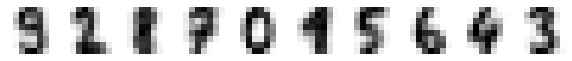

In [2]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(X)

centroids = kmeans.cluster_centers_
_, axes = plt.subplots(nrows=1, ncols=10, figsize=(10, 3))
for ax, image in zip(axes, centroids):
    ax.set_axis_off()
    image = image.reshape(8, 8)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")


b) what is the disagreement distance between the clustering you created above and the clustering created by the labels attached to each image? Briefly explain what this number means in this context. - (10 points)

In [3]:
disagreement_distance = 0

for i in range(len(Y)):
    for j in range(i + 1, len(Y)):
        disagreement_distance += (Y[i] == Y[j]) != (kmeans.labels_[i] == kmeans.labels_[j])

print('The disagreement distance is: ' + str(disagreement_distance))

The disagreement distance is: 98508


->answer

For regrade

c) Download the CIFAR-10 dataset [here](https://www.cs.toronto.edu/~kriz/cifar.html). Open `batch_1` by following the documentation on the web page. Plot a random image from the dataset. - (10 points)

In [ ]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

data_batch_1 = unpickle('data_batch_1')

In [ ]:
rand = random.randint(0, len(data_batch_1['data']))
image = data_batch_1['data'][rand].reshape(3, 32, 32).transpose(1, 2, 0)
plt.axis('off')
plt.imshow(image)

d) This image is 32 x 32 pixels and each pixel is a 3-dimensional object of RGB (Red, Green, Blue) intensities. Using the same image as in c), produce an image that only uses 4 colors (the 4 centroids of the clusters obtained by clustering the image itself using Kmeans). - (10 points)

In [ ]:
def compress_image_using_kmeans(original_image, k=4):
    kmeans_for_K = KMeans(n_clusters=k).fit(original_image.reshape(
        original_image.shape[0] * original_image.shape[1], 3)) 

    new_image = kmeans_for_K.cluster_centers_[kmeans_for_K.labels_]
    new_image = np.clip(new_image.astype(int), 0, 255).reshape(
        original_image.shape[0], original_image.shape[1], 3)
    return new_image

In [ ]:
plt.axis('off')
plt.imshow(compress_image_using_kmeans(image))

e) Write a function that applies this transformation to the entire dataset for any number K of colors. - (10 points)

In [ ]:
def compress_images(dataset, k=4):
    compressed_images = []
    i, n = 0, len(dataset) // 20
    sys.stdout.write("\r [%-20s] %d%% done" % ('=' * (i // n), 5 * (i // n)))
    
    for image in dataset:
        i += 1
        image = image.reshape(3, 32, 32).transpose(1, 2, 0)
        compressed_images.append(compress_image_using_kmeans(image, k))
        if i % (len(dataset) // 20) == 0:
            sys.stdout.write(
                "\r [%-20s] %d%% done" % ('=' * (i // n), 5 * (i // n)))

    return compressed_images

In [ ]:
new_images = compress_images(data_batch_1['data'])

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(15, 5))
fig.suptitle('Original to Compressed Images')

for i, j in zip(np.random.randint(len(new_images), size=10), range(10)):
    axes[0, j].set_axis_off()
    axes[0, j].imshow(data_batch_1['data'][i].reshape(3, 32, 32).transpose(1, 2, 0))
    axes[1, j].set_axis_off()
    axes[1, j].imshow(new_images[i])